In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [2]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_metric

import nltk
from nltk.tokenize import sent_tokenize
from datasets import load_dataset

from tqdm import tqdm
import torch
from datasets import load_dataset

import os

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = "google/pegasus-cnn_dailymail"  # You can use another checkpoint if you prefer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
drive_path = "./drive/MyDrive"

In [6]:
#Get data
df = pd.read_csv(os.path.join(drive_path, 'dataset_writeups_original_cleaned.csv'), sep=',')
df = df.dropna().reset_index()

#Select part of data we want to keep
df = df[['original','cleaned']]

#Select only part of it (makes testing faster)
writeups = df
writeups.head()

,original,cleaned
0,# Body Count\n\nAuthor: [AJ1479](https://githu...,"When you visit the website, you get redirected..."
1,# CCC\n\nAuthor: [roerohan](https://github.com...,"Description: ""You can steal a car if you steal..."
2,# File Library\n\nAuthor: [roerohan](https://g...,"Description: ""This is my file library. I don't..."
3,# Mr. Rami\n\nAuthor: [roerohan](https://githu...,"Description: ""People who get violent get that ..."
4,# Oreo\n\nAuthor: [AJ1479](https://github.com/...,"Description: ""My nephew is a fussy eater and i..."


In [7]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Split the DataFrame into training and test+validation sets
train_writeups, temp_writeups = train_test_split(writeups, test_size=0.2, random_state=42)

# Split the temporary set into test and validation sets
test_writeups, validation_writeups = train_test_split(temp_writeups, test_size=1/2, random_state=42)

# Convert the split DataFrames into datasets.Dataset objects
train_dataset = Dataset.from_pandas(train_writeups)
test_dataset = Dataset.from_pandas(test_writeups)
validation_dataset = Dataset.from_pandas(validation_writeups)

# Create a datasets.DatasetDict object with the train, test, and validation datasets
writeups_dataset = DatasetDict({"train": train_dataset, "test": test_dataset, "validation": validation_dataset})

print(writeups_dataset)

DatasetDict({
    train: Dataset({
        features: ['original', 'cleaned', '__index_level_0__'],
        num_rows: 125
    })
    test: Dataset({
        features: ['original', 'cleaned', '__index_level_0__'],
        num_rows: 16
    })
    validation: Dataset({
        features: ['original', 'cleaned', '__index_level_0__'],
        num_rows: 16
    })
})


In [8]:
split_lengths = [len(writeups_dataset[split])for split in writeups_dataset]

print(f"Split lengths: {split_lengths}")
print(f"Features: {writeups_dataset['train'].column_names}")
print("\nOriginal:")

print(writeups_dataset["test"][0]["original"])

print("\nCleaned:")

print(writeups_dataset["test"][0]["cleaned"])

Split lengths: [125, 16, 16]
Features: ['original', 'cleaned', '__index_level_0__']

Original:
# Birdbuster Video
### Category: Web Exploitation
### Author: James Lowther (Articuler)

## Description
Weren't video rental stores the best?! See if you can break into this one!

## Hints
1. 80s action movies really inject you full of adrenaline!

## Solution
This challenge gives provides you a website with the ability to upload a barcode. The website will "scan" this barcode and will return information about the movie title that was encoded.

1. To solve this challenge, generate a barcode with a SQL injection that returns all rows using an online barcode generator.
    * For example, `' OR 1=1;  --  `
2. Upload the barcode to the website.
3. The flag can be found at the bottom of the returned results.

## Flag
magpie{80s_m0v135_4r3_th3_b35t}

Cleaned:
Hint: "80s action movies really inject you full of adrenaline!"

This challenge gives provides you a website with the ability to upload a bar

In [9]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=4,  # Updated batch size to match training settings
                               device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024, truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=1.0, num_beams=8, max_length=256)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the <n> token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [10]:
pipe = pipeline('summarization', model = model_ckpt)
pipe_out = pipe(writeups_dataset['test'][0]['original'])

print(pipe_out)

[{'summary_text': 'This challenge gives you a website with the ability to upload a barcode .<n>The website will "scan" this barcode and will return information about the movie title that was encoded .'}]


In [11]:
rouge_metric = load_metric('rouge')
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

score = calculate_metric_on_test_ds(writeups_dataset['test'], rouge_metric, model, tokenizer, column_text='original', column_summary='cleaned', batch_size=4) # Updated batch size to match training settings

<ipython-input-11-6f0fdf3fbd4b>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
100%|██████████| 4/4 [00:17<00:00,  4.35s/it]


In [23]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
rouge_before = pd.DataFrame(rouge_dict, index=['model'])
display(rouge_before)

Token indices sequence length is longer than the specified maximum sequence length for this model (1439 > 1024). Running this sequence through the model will result in indexing errors


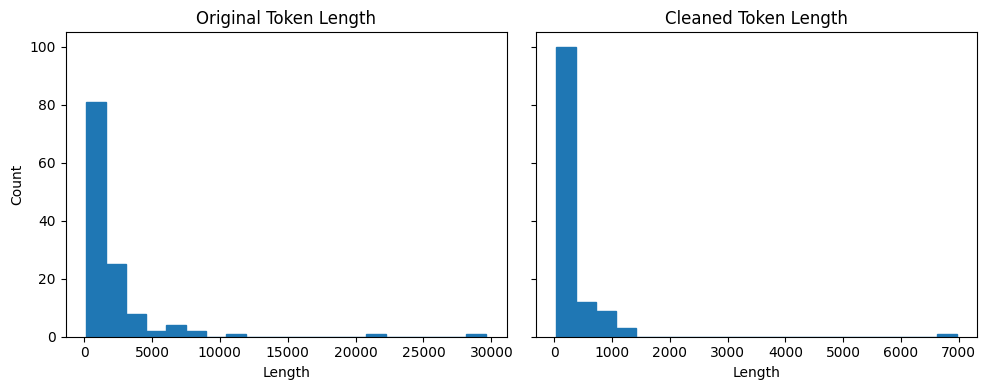

In [13]:
text_token_len = [len(tokenizer.encode(s)) for s in writeups_dataset['train']['original']]
cleaned_token_len = [len(tokenizer.encode(s)) for s in writeups_dataset['train']['cleaned']]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].hist(text_token_len, bins=20, color='C0', edgecolor='C0')
axes[0].set_title("Original Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(cleaned_token_len, bins=20, color='C0', edgecolor='C0')
axes[1].set_title("Cleaned Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [14]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['original'], max_length=1024, truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['cleaned'], max_length=256, truncation=True)
        
    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

writeups_dataset_pt = {split: ds.map(convert_examples_to_features, batched=True) for split, ds in writeups_dataset.items()}

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

In [15]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="model",
    num_train_epochs=500,
    per_device_train_batch_size=4,  # Increased batch size
    per_device_eval_batch_size=4,  # Increased batch size
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1000,
    gradient_accumulation_steps=2,  # Adjusted gradient_accumulation_steps
    fp16=True,  # Enable mixed precision training
    load_best_model_at_end=True
)

In [17]:
from transformers import EarlyStoppingCallback

trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=writeups_dataset_pt["train"],
                  eval_dataset=writeups_dataset_pt["validation"],
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],  # Stop training when validation loss doesn't improve for 10 epochs
)

In [18]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb=100" # Updated settings

In [19]:
trainer.train()

score = calculate_metric_on_test_ds(
    writeups_dataset['test'], rouge_metric, trainer.model, tokenizer, batch_size=4, column_text='original', column_summary='cleaned'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
rouge_after = pd.DataFrame(rouge_dict, index = [f'model'])
display(rouge_before)
display(rouge_after)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,0.572800,1.696125
1000,0.151300,2.463398
1500,0.064500,2.841445
2000,0.031600,3.035351
2500,0.024900,3.156870
3000,0.015900,3.280216
3500,0.015000,3.273090
4000,0.009100,3.344044
4500,0.006900,3.383382
5000,0.007800,3.400877


100%|██████████| 4/4 [00:22<00:00,  5.73s/it]


,rouge1,rouge2,rougeL,rougeLsum
model,0.65758,0.56011,0.607292,0.645744


In [27]:
model_path = os.path.join(drive_path, "cleaning_model")

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

tuned_model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tuned_tokenizer = AutoTokenizer.from_pretrained(model_path)

In [21]:
gen_kwargs = {"length_penalty": 1.0, "num_beams": 8, "max_length": 256}

In [26]:
import random

random_index = random.randint(0, len(writeups_dataset["test"]) - 1)
sample_text = writeups_dataset["test"][random_index]["original"]
reference = writeups_dataset["test"][random_index]["cleaned"]

# Use your fine-tuned model and tokenizer in the pipeline
pipe = pipeline("summarization", model=tuned_model, tokenizer=tuned_tokenizer)

print(f"Random index: {random_index}\n")

print("Original:")
print(sample_text)

print("\nReference Cleaned:")
print(reference)

print("\nModel Cleaned:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Random index: 12

Original:
# panda-facts

Authors: [roerohan](https://github.com/roerohan), [thebongy](https://github.com/thebongy)

Maybe we can call this JSON injection?

# Requirements

- Basic knowledge of Node.js.

# Source

- [index.js](./index.js)
- https://panda-facts.2020.redpwnc.tf/

# Exploitation

```javascript
async function generateToken(username) {
    const algorithm = 'aes-192-cbc'; 
    const key = Buffer.from(process.env.KEY, 'hex'); 
    // Predictable IV doesn't matter here
    const iv = Buffer.alloc(16, 0);

    const cipher = crypto.createCipheriv(algorithm, key, iv);

    const token = `{"integrity":"${INTEGRITY}","member":0,"username":"${username}"}`

    let encrypted = '';
    encrypted += cipher.update(token, 'utf8', 'base64');
    encrypted += cipher.final('base64');
    return encrypted;
}
```

You really just need to notice this function. Notice, the token is not created like `token.username = username`. It's formed in the following way:

```
const toke